## Проект: Аналитика игрового рынка

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math
import warnings
warnings.filterwarnings('ignore')

In [29]:
data = pd.read_csv('games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Промежуточный вывод:** *в данном проекте представлены данные об игровой индустрии с 1980 по 2016 год. В датасете присутствует много пропущенных данных, а так же неподходящие форматы для отдельных столбиков.*

## 1) Подготовка данных ##


In [30]:
#приведем все названия столбиков к нижнему регистру
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [31]:
#проверим наличие явных дубликатов
data.duplicated().sum()

0

In [32]:
columns = data.columns.unique()
for i in ['name', 'platform', 'genre', 'rating']:
    print(i)
    print(data[i].unique())

name
['Wii Sports' 'Super Mario Bros.' 'Mario Kart Wii' ...
 'Woody Woodpecker in Crazy Castle 5' 'LMA Manager 2007'
 'Haitaka no Psychedelica']
platform
['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
genre
['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy' nan]
rating
['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


**Промежуточный вывод:** *при проверке столбцов с строковыми типами данных неявных дубликатов выявленно не было.*

In [42]:
data = data[~data['year_of_release'].isna()]
data['year_of_release'] = data['year_of_release'].astype(np.int32)
data = data[~data['name'].isna()]

**Было принято решени удалить строки с пропусками из столбца 'year_of_release', так как кол-во пропусков составляет небольшую часть от всей БД. Так же привел данные к типу данных int.**



In [43]:
data['rating'] = data['rating'].replace(to_replace=np.nan, value='Without rating')
data['user_score'] = data['user_score'].replace(to_replace='tbd', value=np.nan)
data['user_score'] = pd.to_numeric(data['user_score'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  sum_sales        16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.6+ MB


**Заменил 'tbd' на NaN в столбце 'user_score', так же заменил пропуски в столбике 'rating' на 'Without rating'. Это было сделано для того, чтобы привести все значения в столбике к 1 типу данных**

In [44]:
#суммарные продажи во всех регионах
data['sum_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [45]:
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Without rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Without rating,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,Without rating,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,Without rating,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Without rating,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,Without rating,0.01


**Промежуточный вывод:**
*В некоторых столбиках было пропущенно немого данных, поэтому я решил избавиться от пропусков, в последних 3 столбцах пропущено много значений, и только в столбце 'rating' можно заполнить пропуски. Со столбиками 'critic_score' и 'user_score' ничего нельзя сделать, кроме как поменять тип данных*

*Предполагаю, что такое большое кол-во пропусков связано либо с техническими проблема (не так открылось, данные пропали, битый файл), либо с человеческим фактором (не поставили, забыли дополнить и т.д.)*

## 2) Исследовательский анализ данных ##

[Text(0.5, 1.0, 'Кол-во выпущенных игр по годам')]

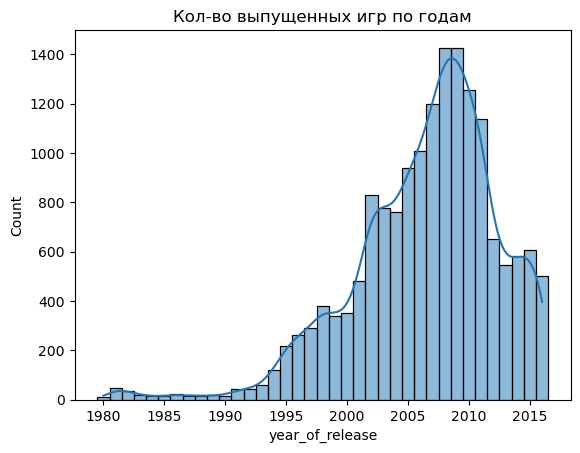

In [46]:
#смотрим сколько игр выпускалось в разные годы
sns.histplot(data=data, x='year_of_release', bins=35, kde=True, discrete=True).set(title='Кол-во выпущенных игр по годам')

**На мой взгляд нужно оставить все периоды, за которые продавались игры, так как можно оценить динамику продаж.**

<AxesSubplot: title={'center': 'Суммарные продажи по платформам'}, ylabel='platform'>

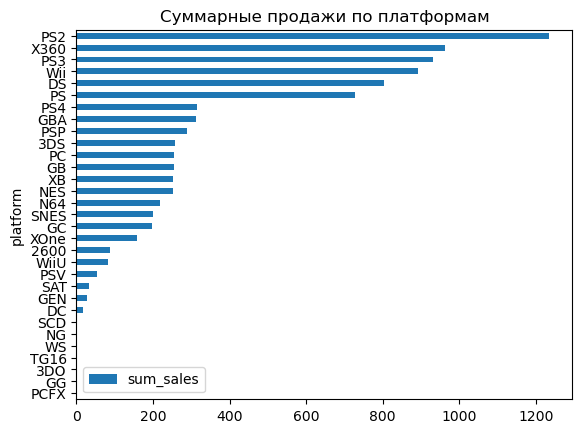

In [47]:
(
    data.pivot_table(index='platform', values='sum_sales', aggfunc='sum')
    .sort_values(by='sum_sales')
    .plot(kind='barh', title='Суммарные продажи по платформам')
)

In [48]:
#найдем наиболее успешные платформы
sales_plat = data.pivot_table(index='platform', values='sum_sales', aggfunc='sum').sort_values(by='sum_sales', ascending=False)
print(sales_plat[:6])
top_plat = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
hm_plat = data.query('platform in @top_plat')
top_plat_sales = data.pivot_table(index=hm_plat['platform'],columns='year_of_release', values='sum_sales', aggfunc='sum')

          sum_sales
platform           
PS2         1233.56
X360         961.24
PS3          931.34
Wii          891.18
DS           802.78
PS           727.58


<AxesSubplot: xlabel='year_of_release', ylabel='platform'>

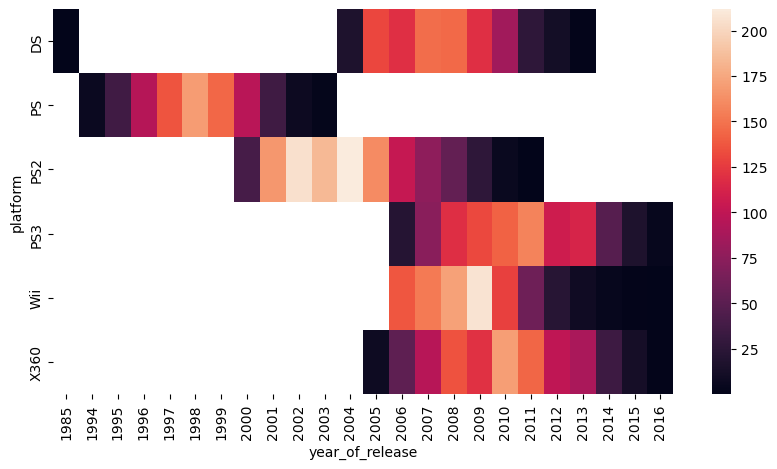

In [49]:
#построим тепловую карту
plt.figure(figsize=(10,5))
sns.heatmap(top_plat_sales)


**По тепловой карте можно сделать вывод, что одно поколение консолей "живет" примерно 6 лет**

In [52]:
#возьмем данные за актуальный период, т.е. c 2014 по 2016 год
actual_per = data.query('year_of_release >= 2014')
actual_per

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Without rating,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Without rating,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,Without rating,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Without rating,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,Without rating,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,Without rating,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Without rating,0.01


<AxesSubplot: ylabel='platform'>

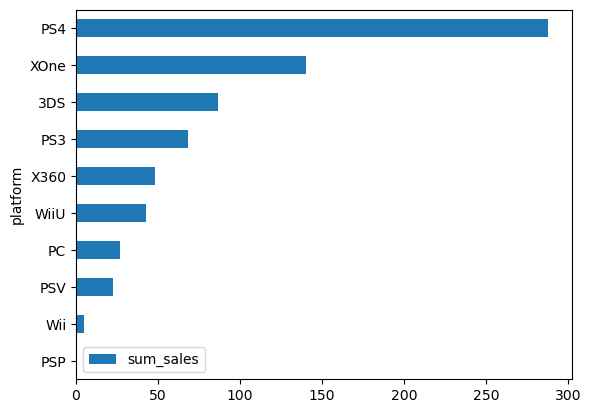

In [54]:
#найдем наиболее успешные платформы за наш актуальный период
actual_plat = (
    actual_per.pivot_table(index='platform', values='sum_sales', aggfunc='sum')
    .sort_values(by='sum_sales')
              )
actual_plat.plot(kind='barh')

**Исходя из результатов графика, можно сказать, что наиболее успешной платформой за 3 года стала PS4. С приходом нового поколения, кол-во продаж возрастает. (У PS4 больше продаж, чем у PS3)**

(0.0, 4.0)

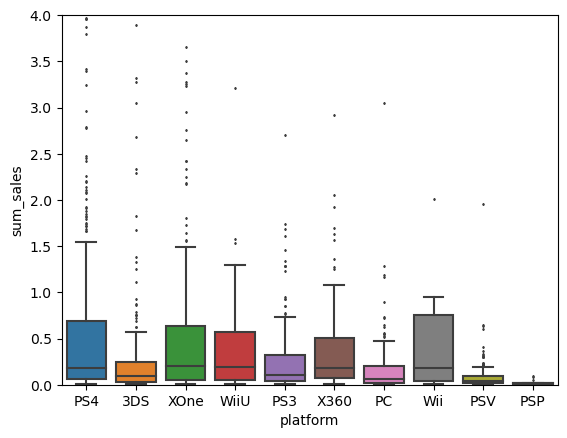

In [81]:
#построим ящик с усами по глобальным продажам игр в разбивке по платформам
#qw = actual_per.pivot_table(index='platform', values='sum_sales', aggfunc='sum').plot(kind='box')
sns.boxplot(data=actual_per, x=actual_per['platform'], y=actual_per['sum_sales'], fliersize=1)
plt.ylim(0,4)


**PS4, XOne и Wii продавались примерно одинаково, что нельзя сказать о PS3, X360 и WiiU. Платформы предыдущих поколений уступают в продажах новым.**

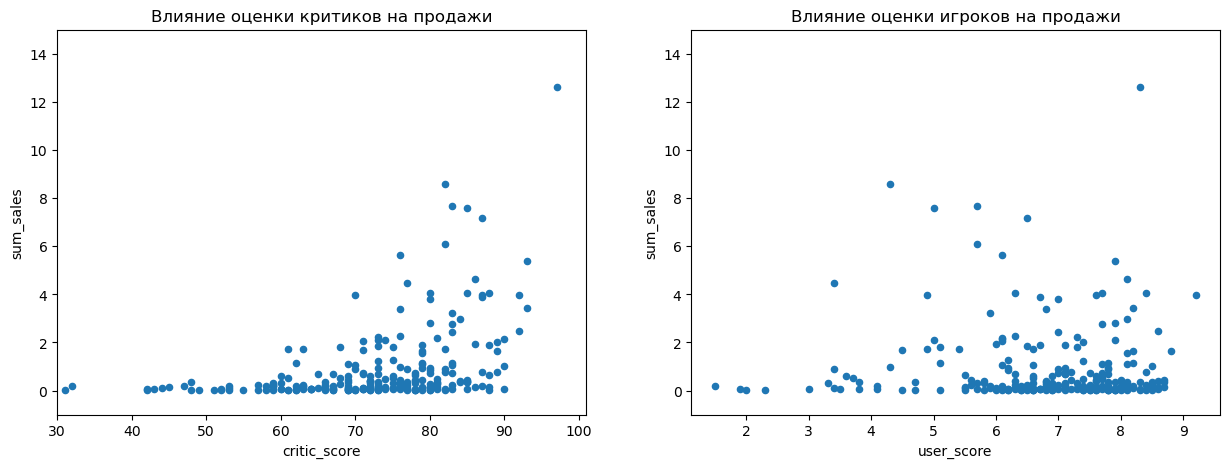

In [83]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ps4_crit = (
    actual_per.query('platform =="PS4"')
    .plot(kind='scatter', x='critic_score', y='sum_sales', ylim=(-1,15),\
          xlim=30, ax=ax[0], title='Влияние оценки критиков на продажи')
    )
ps4_user = (
    actual_per.query('platform =="PS4"')
    .plot(kind='scatter', x='user_score', y='sum_sales', ylim=(-1,15),\
          ax=ax[1], title='Влияние оценки игроков на продажи')
    )


In [89]:
cor = actual_per.query('platform == "PS4"')[['sum_sales', 'critic_score', 'user_score']]
cor.corr()

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.402661,-0.040132
critic_score,0.402661,1.000000,0.546434
user_score,-0.040132,0.546434,1.000000


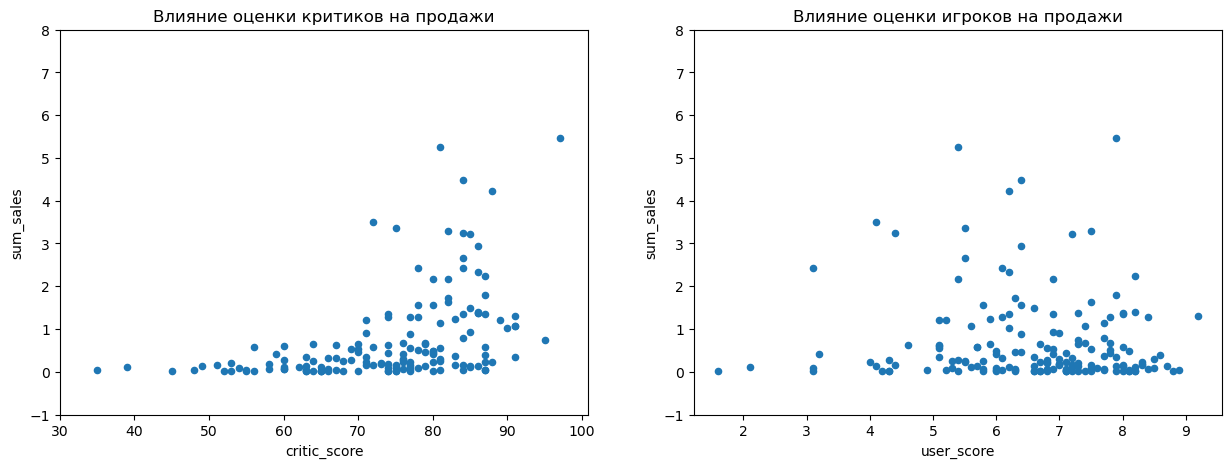

In [93]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
xone_crit = (
    actual_per.query('platform =="XOne"')
    .plot(kind='scatter', x='critic_score', y='sum_sales', ylim=(-1,8),\
          xlim=30, ax=ax[0], title='Влияние оценки критиков на продажи')
    )
xone_user = (
    actual_per.query('platform =="XOne"')
    .plot(kind='scatter', x='user_score', y='sum_sales', ylim=(-1,8),\
          ax=ax[1], title='Влияние оценки игроков на продажи')
    )

In [94]:
cor = actual_per.query('platform == "XOne"')[['sum_sales', 'critic_score', 'user_score']]
cor.corr()

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.428677,-0.070384
critic_score,0.428677,1.000000,0.440977
user_score,-0.070384,0.440977,1.000000


**Исходя из полученных данных, можно сделать вывод, что на продажи немного влияет оценка от критиков, потому что, как мне известно, критикам/журналистам выдают игры раньше игроков, поэтому, возможно, некторые люди принимают свои дейстивия по покупке на основе отзывов от критиков. Отзыв игроков вообще не вляет на продажи, потому что игроки ставят свои оценки уже после выхода игры.**

**А вообще, люди, если ждут какую-то игру, они ёё приобретут 100%, не смотря на отзывы. (основано на собственном опыте)**

**С другими платформами такая же история, только продаж меньше, так как популярность на рынке ниже.**

<AxesSubplot: title={'center': 'Соотношение продаж по жанрам'}, ylabel='genre'>

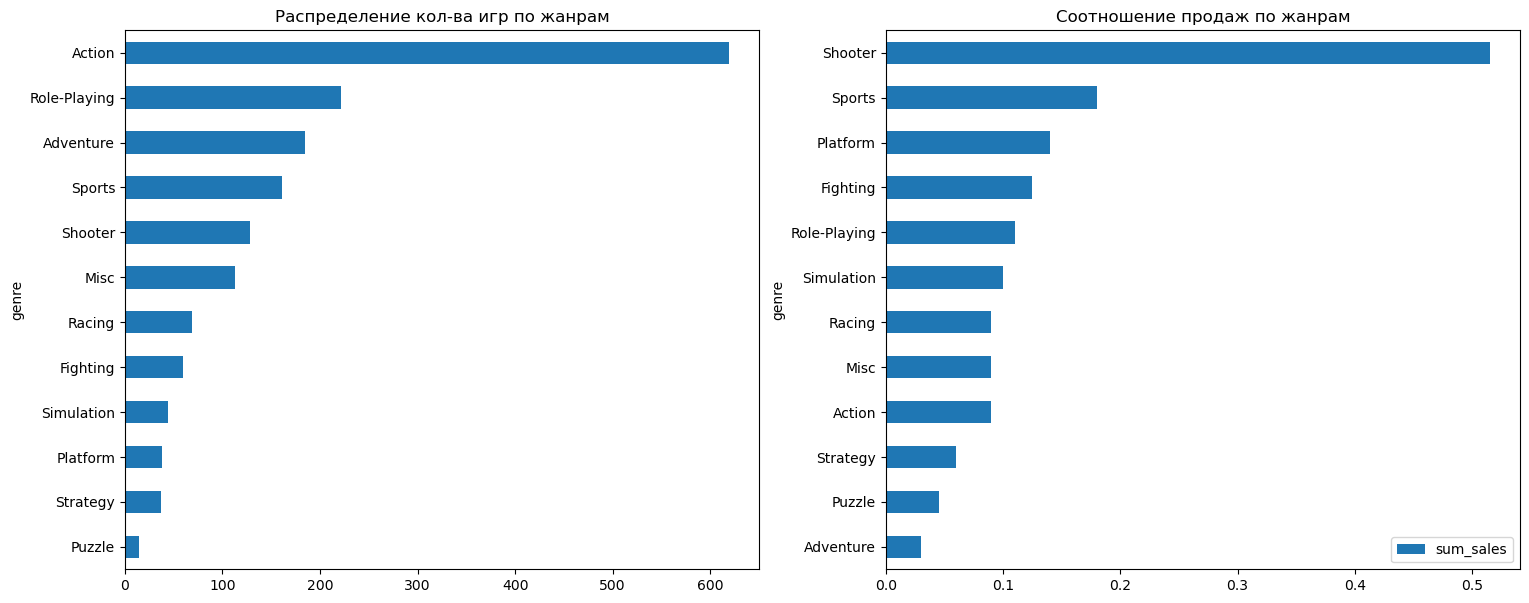

In [96]:
fig, ax = plt.subplots(1,2, figsize=(18, 7))
(
    actual_per.pivot_table(index='genre', values='name', aggfunc='count')
    .sort_values(by='name').plot(kind='barh', legend=False, title='Распределение кол-ва игр по жанрам', ax=ax[0])
)

(
    actual_per.pivot_table(index='genre', values='sum_sales', aggfunc='median')
    .sort_values(by='sum_sales').plot(kind='barh', title='Соотношение продаж по жанрам', ax=ax[1])
)

**Самыми прибыльными жанром стал Shooter, это потому что игры этого жанра самые выстробованные, так как людям после, например работы, хочется просто расслабиться. Так же этот жанр популярный по той причине, что много соревновательных игр в этой категории.**

**Самые низкие продажи у жанра Adventure, скорее всего, потому что в них играю дети дошкольного возраста, остальным они просто не интересны.**

**Промежуточный вывод:**
*Самыми популярными платформами стали PS4, XOne, Wii. На эти игровые приставки продалось большое кол-во игр в жанре Shooter, которое в небольшой мере зависит от предварительной оценки критиков.*

## 3) Составьте портрет пользователя каждого региона ##

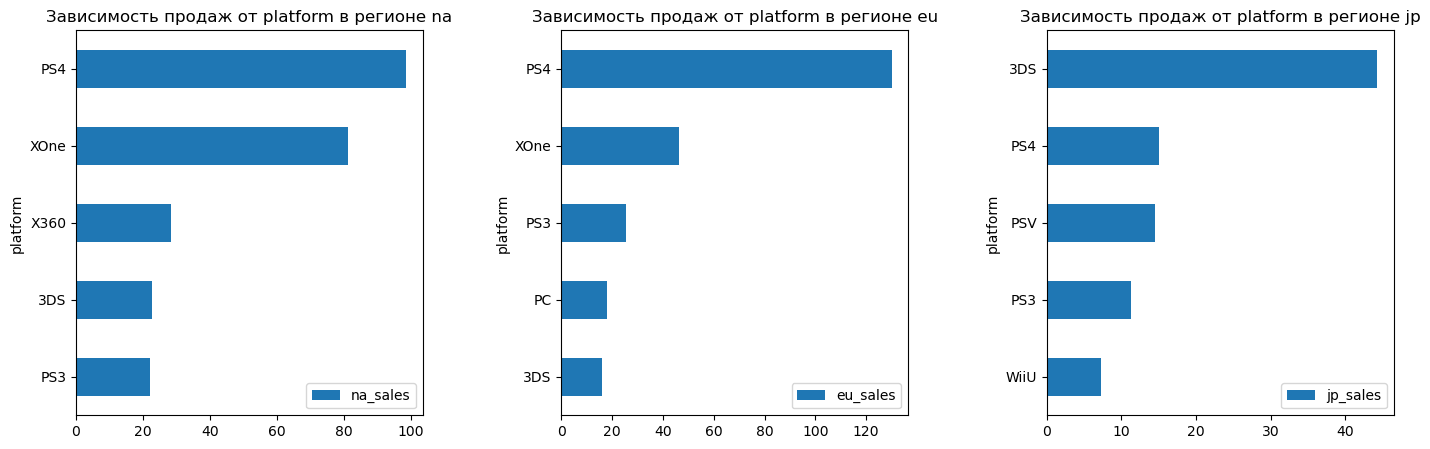

In [104]:
#покажем графически, какие платформы популярны в каждом регионе
fig, ax = plt.subplots(1,3, figsize=(17, 5))
plt.subplots_adjust(wspace=0.4)

def sub_plt(ind, val, pos):
    reg = val.split('_')[0]
    (
    actual_per.pivot_table(index=ind, values=val, aggfunc='sum')
    .sort_values(by=val)
    .tail()
    .plot(kind='barh', ax=ax[pos], title=f'Зависимость продаж от {ind} в регионе {reg}')
    )
    
sub_plt('platform', 'na_sales', 0)
sub_plt('platform', 'eu_sales', 1)
sub_plt('platform', 'jp_sales', 2)


In [105]:
#выведем долю продаж каждой платформы по регионам
def top_5_plat(col):
    na_s = actual_per.pivot_table(index='platform', values=[col,'sum_sales'], aggfunc='sum').sort_values(by=col, ascending=False)
    na_s['%_sales'] = na_s[col] / na_s['sum_sales']
    na_s = na_s.drop('sum_sales', axis=1)
    display(na_s[:5])
    
top_5_plat('na_sales')
top_5_plat('eu_sales')
top_5_plat('jp_sales')

,na_sales,%_sales
platform,,
PS4,98.61,0.342218
XOne,81.27,0.579011
X360,28.30,0.586893
3DS,22.64,0.261191
PS3,22.05,0.323409


,eu_sales,%_sales
platform,,
PS4,130.04,0.451293
XOne,46.25,0.329510
PS3,25.54,0.374597
PC,17.97,0.664325
3DS,16.12,0.185971


,jp_sales,%_sales
platform,,
3DS,44.24,0.510383
PS4,15.02,0.052126
PSV,14.54,0.649107
PS3,11.22,0.164564
WiiU,7.31,0.170079


**Исхоя из результатов, можно сказать, что в каждом регионе предпочитают местных производителей платформ, кроме UE, так как там очень полюбилась японская платформа от Sony. В NA преобладает платформа от Microsoft, когда в то время Nintendo захватила японский рынок.**

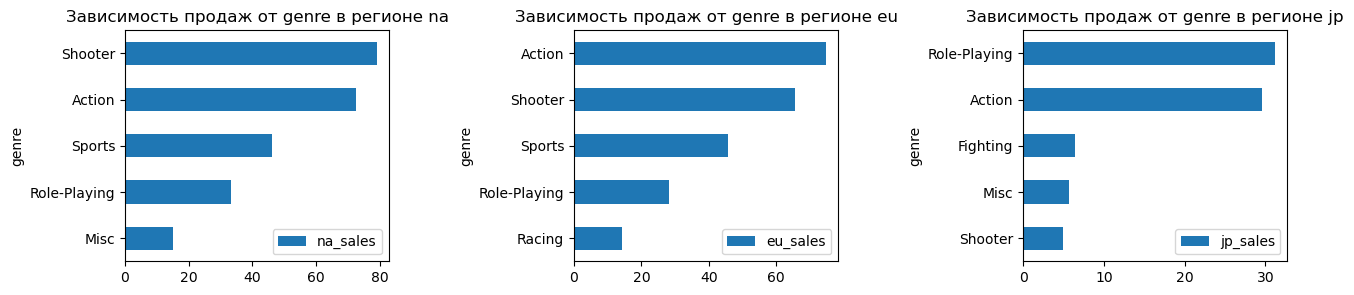

In [107]:
#покажем графически, какие жанры популярны в каждом регионе
fig, ax = plt.subplots(1,3, figsize=(15, 3))
plt.subplots_adjust(wspace=0.7)

sub_plt('genre', 'na_sales', 0)
sub_plt('genre', 'eu_sales', 1)
sub_plt('genre', 'jp_sales', 2)


**В регионах NA и EU популярные жанры почти одинаковы, так как там предпочитают одиночные игры либо мультиплеерные шутеры западных издателей, в то время как в JP предпочитают RPG от местных издателей, но в последенее время жанр Action набирает популярность в Японии.**

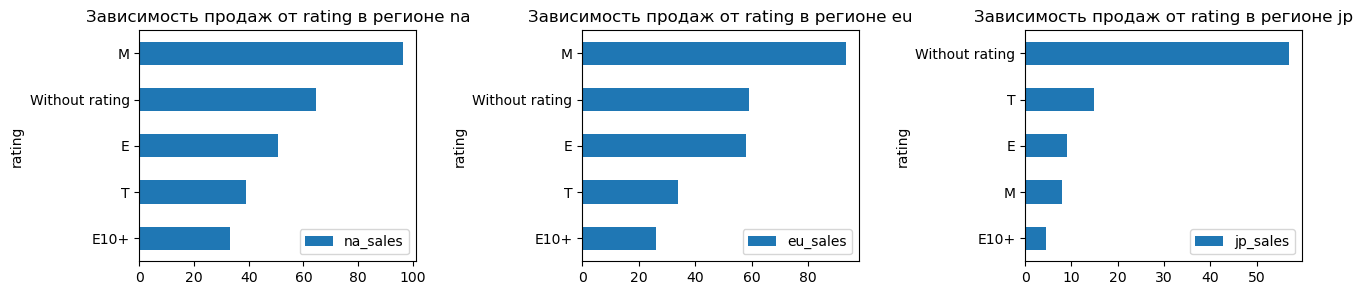

In [108]:
def rating_sales(ind, val, pos):
    reg = val.split('_')[0]
    (
    actual_per.pivot_table(index=ind, values=val, aggfunc='sum')
    .sort_values(by=val)
    .plot(kind='barh', ax=ax[pos], title=f'Зависимость продаж от {ind} в регионе {reg}')
    )
    

fig, ax = plt.subplots(1,3, figsize=(15, 3))
plt.subplots_adjust(wspace=0.6)
rating_sales('rating', 'na_sales', 0)
rating_sales('rating', 'eu_sales', 1)
rating_sales('rating', 'jp_sales', 2)

**Графики показывают, что в регионах NA и EU предпочитают игры с рейтингом М (для лиц старше 17+ лет), в то время как в JP предпочитают игры, пользуясь методом исключения, рейтинга AO (только для лиц достигших 18+ лет) (но это догадки). Ответ: да, рейтинг вляет на продажи игр.**

**Промежуточный вывод:**
*В каждом регионе преобладают консоли разных компаний, так же в каждом регионе есть свои популярные жанры с разными рейтингами, но в большестве люди предпочитают игры с возрастным рейтингом 17+ и выше.*

1. **Портрет типичного игрока в регионе NA:**

*Играет на консоли от Microsoft (X360), предпочитает игры жанра Action и Shooter с рейтингом 17+*

2. **Портрет типичного игрока в регионе EU:**

*Играет на консоли от Sony (PS3), предпочитает игры жанра Action и Shooter с рейтингом 17+*

3. **Портрет типичного игрока в регионе JP:**

*Играет на консоли от Nintendo (3DS), предпочитает игры жанра Action и RPG с рейтингом 18+**

## 4) Проверьте гипотезы

In [120]:
#Подготовим выборки примерно одинакового размера
rand_samp_xbox = actual_per[(~actual_per['user_score'].isna()) & (actual_per['platform'] == 'XOne')]
print(len(rand_samp_xbox))
rand_samp_pc = actual_per[(~actual_per['user_score'].isna()) & (actual_per['platform'] == 'PC')]
print(len(rand_samp_pc))

165
122


**Гипотеза:** *Средние пользовательские рейтинги платформ Xbox One и PC одинаковые*

**Алтернативная гипотеза:** *Средние пользовательские рейтинги платформ Xbox One и PC неодинаковы*


In [121]:
from scipy import stats as st
sample_1 = list(rand_samp_xbox['user_score'])
sample_2 = list(rand_samp_pc['user_score'])
results = st.ttest_ind(sample_1, sample_2, equal_var = False)

alpha = 0.05

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получается отвергнуть гипотезу')

p-значение:  0.11601398086668832
Не получается отвергнуть гипотезу


In [124]:
#Подготовим выборки примерно одинакового размера
rand_samp_act = actual_per[(~actual_per['user_score'].isna()) & (actual_per['genre'] == 'Action')]
rand_samp_sport = actual_per[(~actual_per['user_score'].isna()) & (actual_per['genre'] == 'Sports')]

**Гипотеза:** *Средние пользовательские рейтинги жанров Action и Sports разные*

**Альтернативная гипотеза:** *Средние пользовательские рейтинги жанров Action и Sports равны*

In [127]:
sample_1 = list(rand_samp_sport['user_score'])
sample_2 = list(rand_samp_act['user_score']) 

results = st.ttest_ind(sample_1, sample_2, equal_var = False)

alpha = 0.05

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получается отвергнуть гипотезу')

p-значение:  1.1825550382644557e-14
Отвергаем гипотезу


**Пояснения:**

*Нулевая гипотеза была уже сформулирована в задании, а альтернативную гипотезу формулировал отталкиваясь от нулевой, если нулевая гипотеза была "... равны", то я брал алтернитвную "...не равны" (либо больше, либо меньше)*
Ко всем гипотезам был применен метод scipy.stats.ttest_ind() 

## Общий вывод

**В полученной БД было много пропущенных значнений, это, скорее всего, связано с техническими проблемами (битый файл). После анализа таблицы, было принято решение удалить значения с пропусками, которые составляют около 1% всех данных, остальные пропуски были заполнены, кроме данных в столбцах с оценками критиков и игроков, так как там пропущенного достаточно значений, которые мы не можем заполнить.**

**Далее, в первичном анализе данных, были сделаны выводы, что за все время (с 1980 до 2016) самой успешной консолью была PS2, так как на эту платформу было продано рекордное кол-во игр. В период с 2010 по 2016 год в лидеры вышла приставка PS3, X360 лишь немного уступал. Кол-во игр, проданных на консоли, в малой степени зависит от оценки критиков, а оценки игроков вообще не влияют на продажи игр. В основном пользователи предпочитают игры жанра Action и Shooter, а игрокам в Японии нравится жанр RPG. Игроки регионов NA и EU почти предпочитают одни и те же игры.**

**После проверки гипотезы о том, что средние пользовательские рейтинги равна как на XOnе, так и на PC, не была отвергнута, так как значение p-value оказалось больше уровня значимости alpha**

**Гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports разные была отвергнута, так как значение p-value оказалось меньше уровня значимости alpha**